In [283]:
import pandas as pd 
import numpy as np
from datetime import date
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import sidetable
import researchpy as rp
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosistest
warnings.filterwarnings('ignore') 
# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


# Barra de progreso de un proceso
# ------------------------------------------------------------------------------
from tqdm import tqdm

In [284]:
df = pd.read_csv("../datos/bikes_eda.csv", index_col=0)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,2018-01-01,winter,0,1,1,1,2,14.110847,18.18125,80.5833,10.749882,985
1,2,2018-01-02,winter,0,1,0,2,2,14.902598,17.68695,69.6087,16.652113,801
2,3,2018-01-03,winter,0,1,0,3,1,8.050924,9.47025,43.7273,16.636703,1349
3,4,2018-01-04,winter,0,1,0,4,1,8.200000,10.60610,59.0435,10.739832,1562
4,5,2018-01-05,winter,0,1,0,5,1,9.305237,11.46350,43.6957,12.522300,1600


> Filtro mis datos por verano

In [285]:
dfv = df[df['season']=='summer']
dfv

,instant,dteday,season,yr,mnth,holiday,weekday,weathersit,temp,atemp,hum,windspeed,cnt
171,172,2018-06-21,summer,0,6,0,4,2,27.914153,31.88230,77.0417,11.458675,4835
172,173,2018-06-22,summer,0,6,0,5,1,30.066653,34.69145,70.7500,11.541554,4507
173,174,2018-06-23,summer,0,6,0,6,2,29.861653,34.69165,70.3333,15.999868,4790
174,175,2018-06-24,summer,0,6,0,7,1,29.690847,32.82915,57.3333,14.875675,4991
175,176,2018-06-25,summer,0,6,0,1,1,28.495000,32.16565,48.3333,14.041257,5202
...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,626,2019-09-18,summer,1,9,0,4,2,25.556653,28.25335,87.2500,23.958329,4073
626,627,2019-09-19,summer,1,9,0,5,1,22.652500,27.02020,53.6667,14.416725,7591
627,628,2019-09-20,summer,1,9,0,6,1,22.413347,26.60960,61.8333,7.917189,7720
628,629,2019-09-21,summer,1,9,0,7,1,24.565847,28.59855,66.8750,10.333343,8167


In [286]:
dfv.reset_index(inplace=True, drop=True)

In [287]:
dfv['season'].unique()

array(['summer'], dtype=object)

## EDA

In [288]:
dfv.shape

(188, 13)

In [289]:
dfv.dtypes

instant         int64
dteday         object
season         object
yr              int64
mnth            int64
holiday         int64
weekday         int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

In [290]:
dfv.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

In [291]:
dfv.duplicated().sum()

0

In [292]:
# Vemos que la unica season que tenemos es verano --> esta columna la dejo porque si luego queremos juntar df tengamos punto de referencia

categoricas = dfv.select_dtypes(include='object')
categoricas.describe(include='object')

,dteday,season
count,188,188
unique,188,1
top,2018-06-21,summer
freq,1,188


In [293]:
numericas = (dfv.select_dtypes(include=['int64', 'float64'])).drop('instant', axis=1)
numericas.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
yr,188.0,0.500000,0.501335,0.000000,0.000000,0.500000,1.000000,1.000000
mnth,188.0,7.691489,0.948137,6.000000,7.000000,8.000000,8.000000,9.000000
holiday,188.0,0.021277,0.144690,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,188.0,4.026596,2.009160,1.000000,2.000000,4.000000,6.000000,7.000000
weathersit,188.0,1.297872,0.503034,1.000000,1.000000,1.000000,2.000000,3.000000
temp,188.0,28.958682,2.904749,19.235847,27.350413,29.297903,30.758538,35.328347
atemp,188.0,32.794920,3.602803,12.120000,30.926987,32.828750,34.904637,42.044800
hum,188.0,63.348206,11.934864,36.000000,55.083300,63.500000,71.260425,93.956500
windspeed,188.0,11.530366,3.988275,4.292744,8.781405,11.062705,14.000136,25.166339
cnt,188.0,5644.303191,1459.800381,1115.000000,4586.500000,5353.500000,6929.250000,8714.000000


Miro los outliers

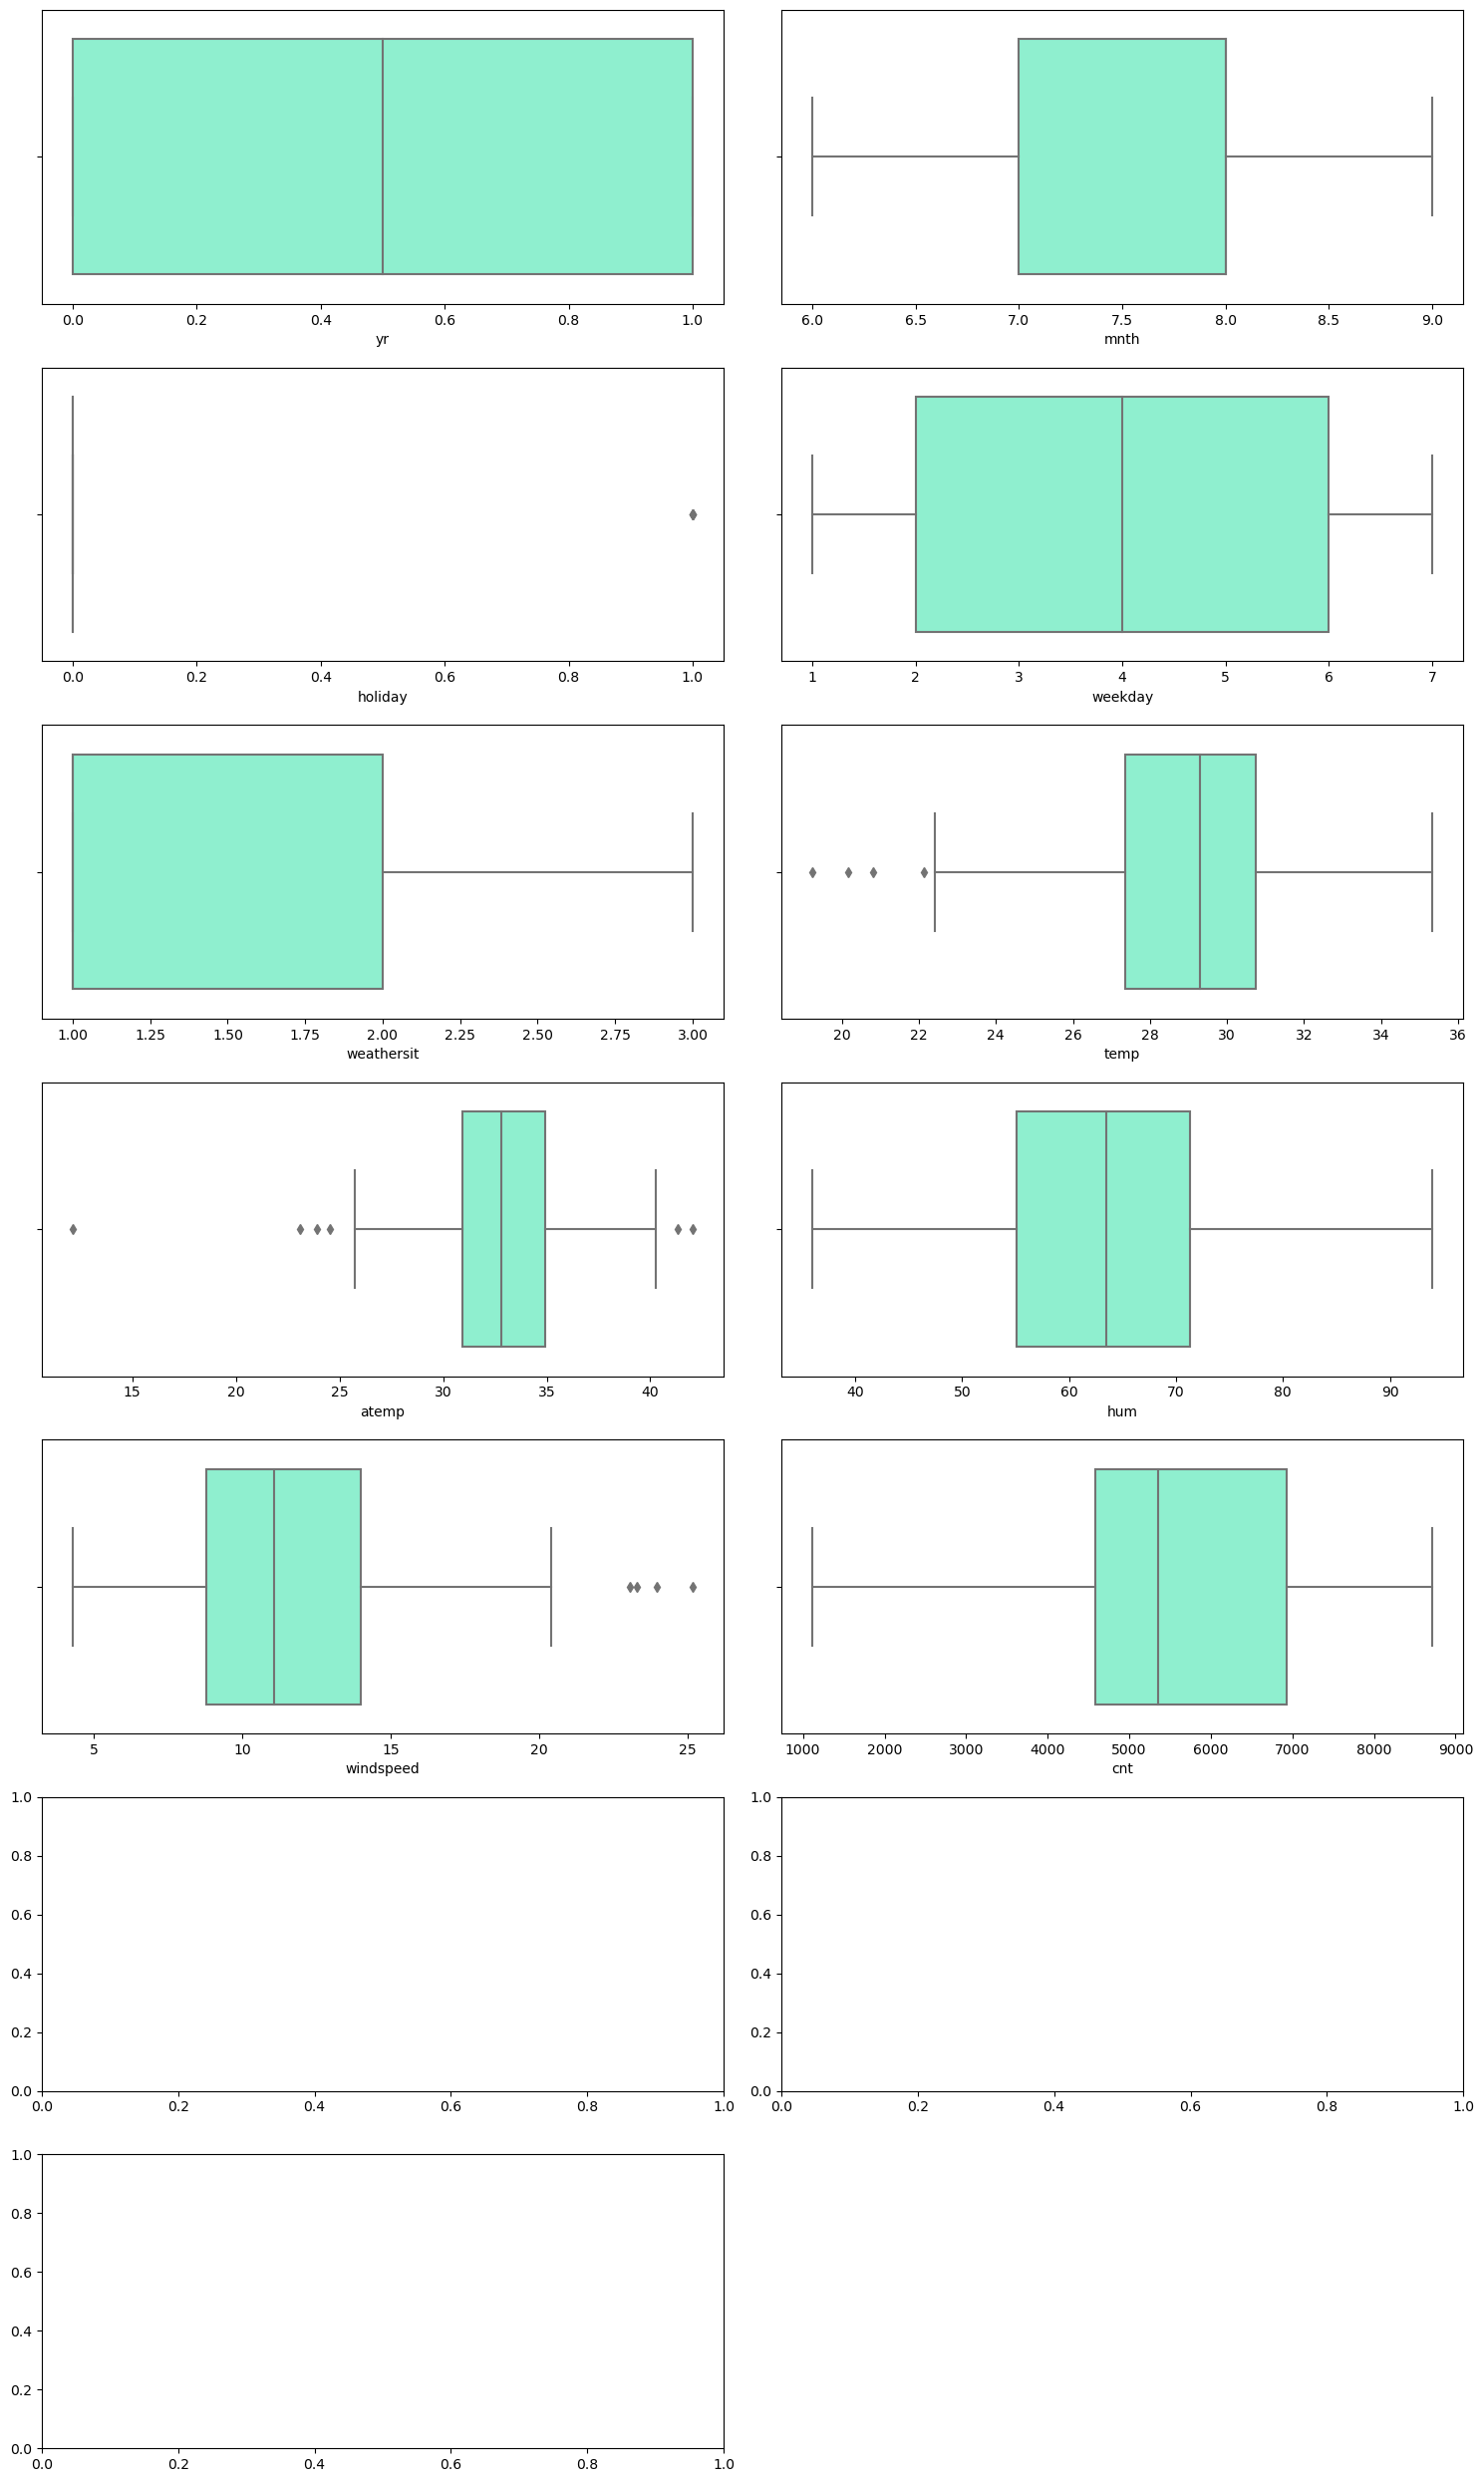

In [294]:
fig, axes = plt.subplots(7, 2, figsize=(15,25))

axes = axes.flat

for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = numericas[columna], data = dfv, ax=axes[indice], color = "aquamarine"); # para trazar una línea de densidad

    
plt.tight_layout()
fig.delaxes(axes[-1])
plt.show()

Como podemos ver en los resutlados de los outliers obtenidos, esta estación incluye los meses des de junio a septiembre, y la mayoría de días son laborables, aunque tenemos outliers que se refieren a días festivos o no lavorables.

También podemos ver outliers en la temperatura, donde vemos que en contadas ocasiones tenemos temperaturas que bajan por debajo de la mínima, llegando a los 19 grados.

Por lo que hace la sensación termica, encontramos outliers por encima y por debajo de las maximas (40 grados) y minimas (24 grados).

Si nos fijamos en el windspeed, vemos también determinados outliers que nos indican vientos superiores a los máximos.

Finalmente, en los casual users, vemos que en esta estación del año se nos dan varios casos en los que tenemos usurios casuales. Esto puede ser a que verano es una estación vacacional.

### Sacamos los outliers

In [295]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(dataframe[col], 25)
        Q3 = np.nanpercentile(dataframe[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) |(dataframe[col] > Q3 + outlier_step)]
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        
    
    return dicc_indices

#### sacamos los outliers para temperatura

In [296]:
outliers_temp = detectar_outliers(['temp'], dfv)
outliers_temp

{'temp': [77, 87, 88, 89]}

In [297]:
valores = outliers_temp.values()
valores = list({indice for sublista in valores for indice in sublista})
valores

[88, 89, 77, 87]

In [298]:
dfv.loc[valores]

,instant,dteday,season,yr,mnth,holiday,weekday,weathersit,temp,atemp,hum,windspeed,cnt
88,260,2018-09-17,summer,0,9,0,1,2,20.158347,23.92560,71.8333,12.708225,4511
89,261,2018-09-18,summer,0,9,0,2,1,20.807500,24.52685,69.5000,11.958361,4274
77,249,2018-09-06,summer,0,9,0,4,3,22.140000,25.76000,88.6957,23.044181,2710
87,259,2018-09-16,summer,0,9,0,7,2,19.235847,23.07375,59.0417,11.000261,4760


#### sacamos los outliers para atemp

In [299]:
outliers_atemp = detectar_outliers(['atemp'], dfv)
outliers_atemp

{'atemp': [30, 31, 87, 88, 89, 151]}

In [300]:
valores2 = outliers_atemp.values()
valores2 = list({indice for sublista in valores2 for indice in sublista})
valores2

[151, 87, 88, 89, 30, 31]

In [301]:
dfv.loc[valores2]

,instant,dteday,season,yr,mnth,holiday,weekday,weathersit,temp,atemp,hum,windspeed,cnt
151,594,2019-08-17,summer,1,8,0,7,1,29.656653,12.12000,57.0833,15.500718,7148
87,259,2018-09-16,summer,0,9,0,7,2,19.235847,23.07375,59.0417,11.000261,4760
88,260,2018-09-17,summer,0,9,0,1,2,20.158347,23.92560,71.8333,12.708225,4511
89,261,2018-09-18,summer,0,9,0,2,1,20.807500,24.52685,69.5000,11.958361,4274
30,202,2018-07-21,summer,0,7,0,6,2,33.415000,41.31855,69.1250,14.875407,3784
31,203,2018-07-22,summer,0,7,0,7,1,34.781653,42.04480,58.0417,8.917700,3387


#### sacamos los outliers para windspeed

In [302]:
outliers_windspeed = detectar_outliers(['windspeed'], dfv)
outliers_windspeed

{'windspeed': [67, 77, 99, 183]}

In [303]:
valores3 = outliers_windspeed.values()
valores3 = list({indice for sublista in valores3 for indice in sublista})
valores3

[99, 67, 77, 183]

In [304]:
dfv.loc[valores3]

,instant,dteday,season,yr,mnth,holiday,weekday,weathersit,temp,atemp,hum,windspeed,cnt
99,542,2019-06-26,summer,1,6,0,4,1,25.864153,29.73520,37.3333,23.292014,7442
67,239,2018-08-27,summer,0,8,0,1,2,27.880000,31.77780,85.0000,25.166339,1115
77,249,2018-09-06,summer,0,9,0,4,3,22.140000,25.76000,88.6957,23.044181,2710
183,626,2019-09-18,summer,1,9,0,4,2,25.556653,28.25335,87.2500,23.958329,4073


## Analizar las relaciones entre las variables. 


### Variable respuesta

In [305]:
dfv.head(2)

,instant,dteday,season,yr,mnth,holiday,weekday,weathersit,temp,atemp,hum,windspeed,cnt
0,172,2018-06-21,summer,0,6,0,4,2,27.914153,31.88230,77.0417,11.458675,4835
1,173,2018-06-22,summer,0,6,0,5,1,30.066653,34.69145,70.7500,11.541554,4507


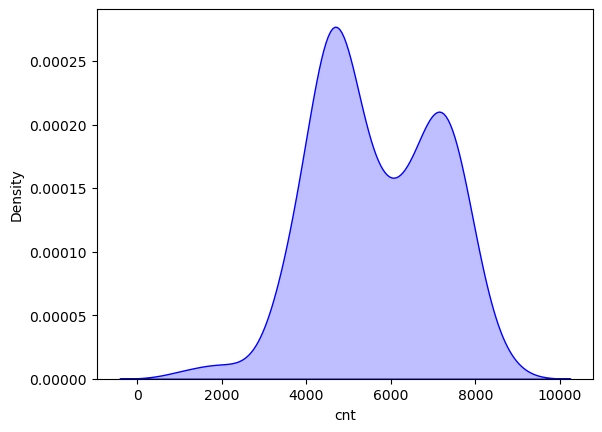

In [306]:
# vamos a ver visualmente como está distribuida la variable respuesta

sns.distplot(
    dfv["cnt"], 
    hist = False, 
    color = "blue", 
    kde_kws = {"shade": True, "linewidth": 1});

### Variables predictoras

Al igual que con la variable respuesta debemos conocer como son nuestras variables predictoras, como se relacionan entre ellas y como lo hacen con la variable respuesta.

Vamos a ello:

#### Variables numéricas

In [307]:
# exploramos cuáles son los principales estadísticos de las variables numéricas

dfv.select_dtypes(include = np.number).describe().T


,count,mean,std,min,25%,50%,75%,max
instant,188.0,401.000000,184.998771,172.000000,218.750000,401.000000,583.250000,630.000000
yr,188.0,0.500000,0.501335,0.000000,0.000000,0.500000,1.000000,1.000000
mnth,188.0,7.691489,0.948137,6.000000,7.000000,8.000000,8.000000,9.000000
holiday,188.0,0.021277,0.144690,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,188.0,4.026596,2.009160,1.000000,2.000000,4.000000,6.000000,7.000000
weathersit,188.0,1.297872,0.503034,1.000000,1.000000,1.000000,2.000000,3.000000
temp,188.0,28.958682,2.904749,19.235847,27.350413,29.297903,30.758538,35.328347
atemp,188.0,32.794920,3.602803,12.120000,30.926987,32.828750,34.904637,42.044800
hum,188.0,63.348206,11.934864,36.000000,55.083300,63.500000,71.260425,93.956500
windspeed,188.0,11.530366,3.988275,4.292744,8.781405,11.062705,14.000136,25.166339


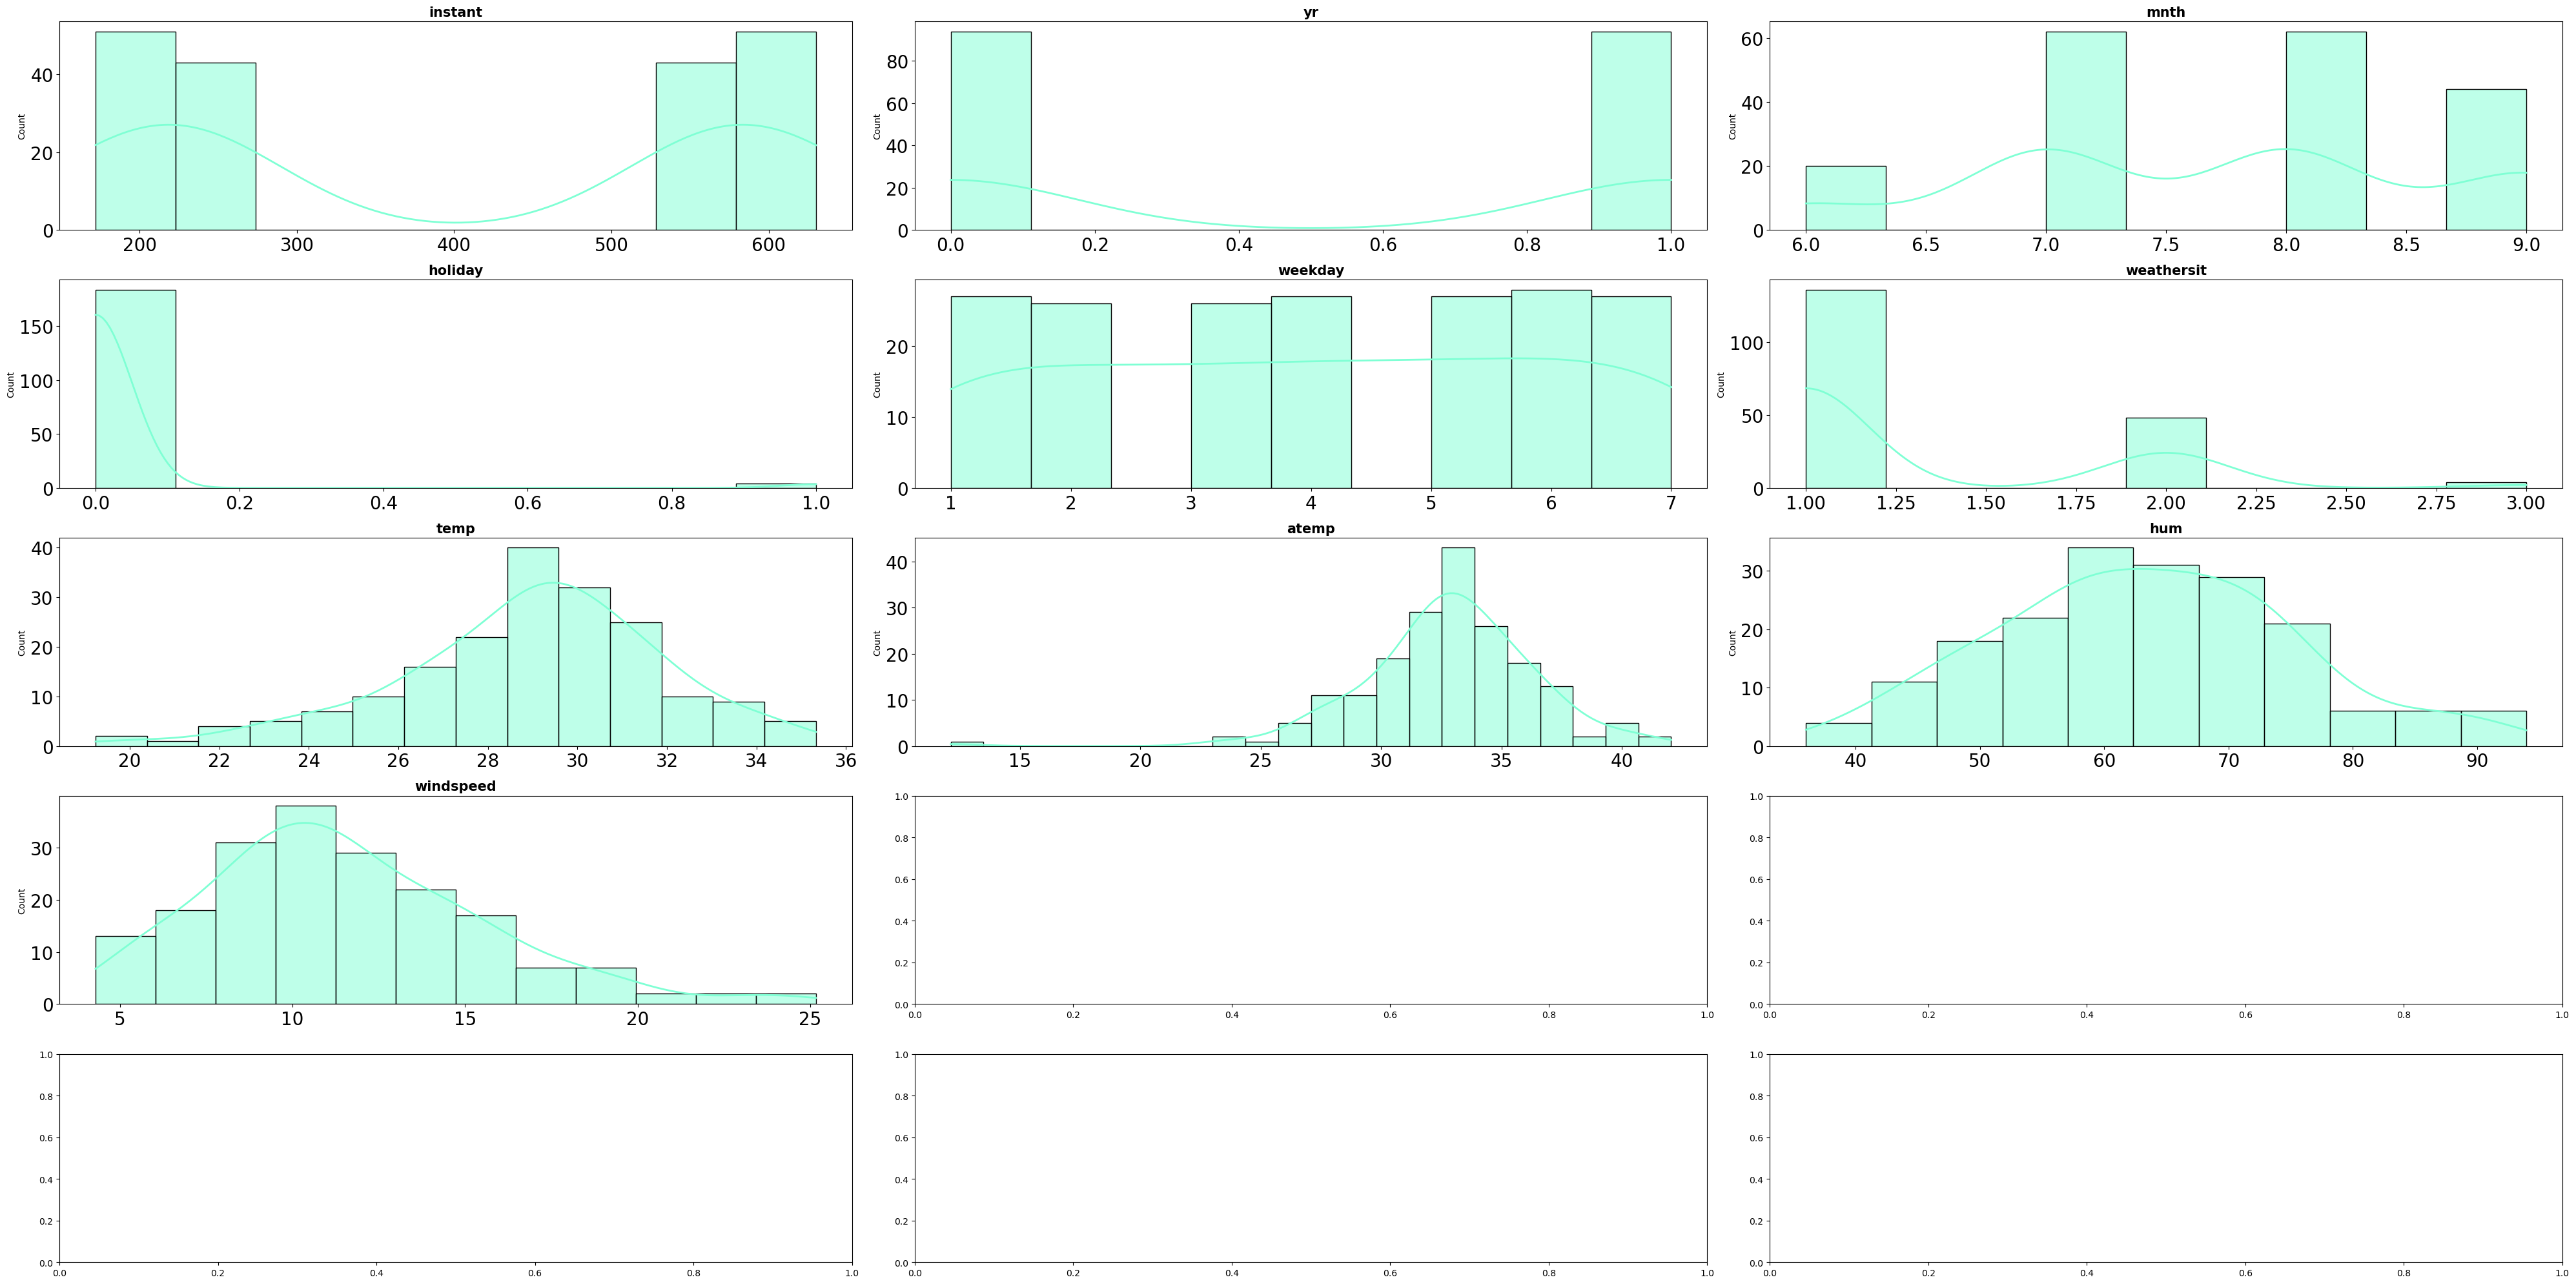

In [308]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================

fig, axes = plt.subplots(nrows = 5, ncols = 3, figsize = (40, 20))


axes = axes.flat

columnas_numeric = dfv.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("cnt")

for i, colum in enumerate(columnas_numeric): 
    sns.histplot(
        data = dfv,
        x = colum,
        kde = True, 
        color = "aquamarine", 
        line_kws = {"linewidth": 2}, # para indicar el ancho de las líneas de las barras
        alpha = 0.5, # para especificar la transparencia del color
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")

fig.tight_layout()
#fig.delaxes(axes[-1])
#fig.delaxes(axes[-2])
#fig.delaxes(axes[-3]);

    


In [309]:
dfv.dtypes

instant         int64
dteday         object
season         object
yr              int64
mnth            int64
holiday         int64
weekday         int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

In [310]:
dfv['yr'].unique()

array([0, 1])

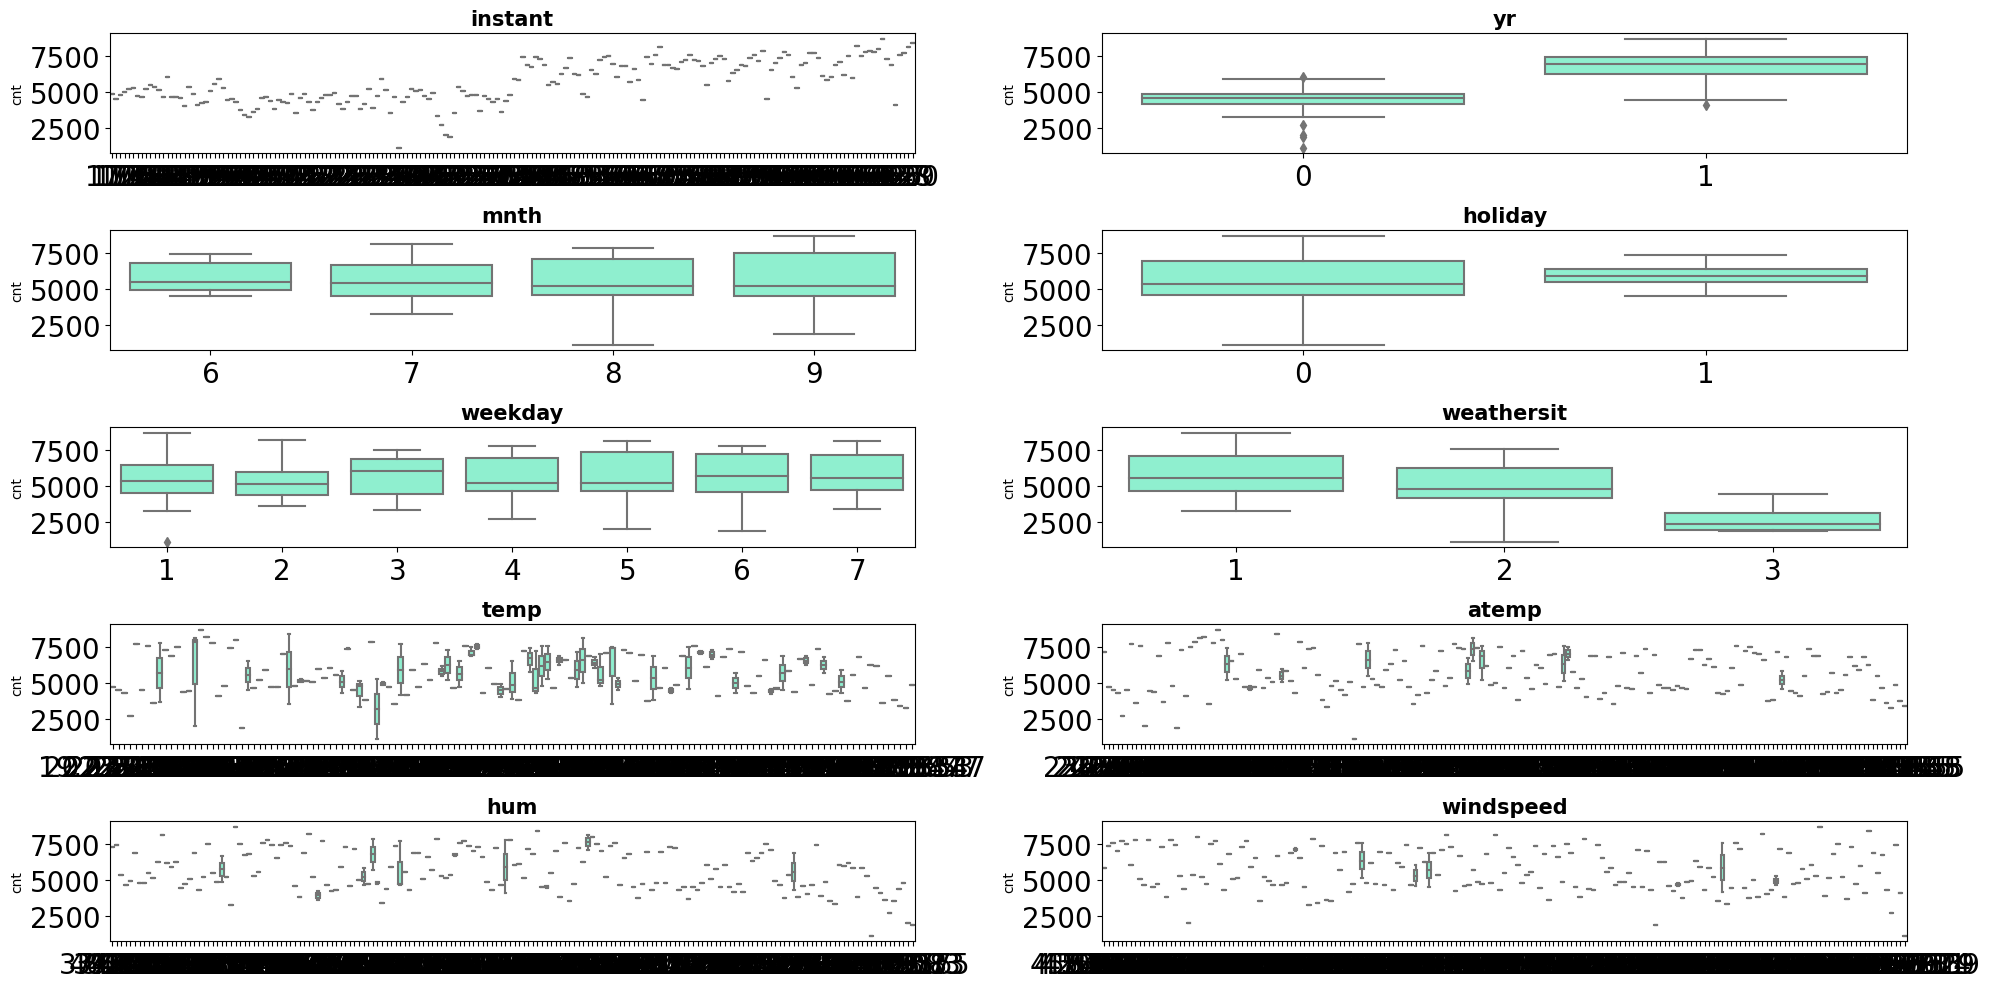

In [311]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (20, 10))


axes = axes.flat

columnas_numeric = dfv.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("cnt")

for i, colum in enumerate(columnas_numeric): 
    sns.boxplot(
        data = dfv,
        x = colum,
        y = 'cnt',
        color = "aquamarine", 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")

fig.tight_layout()

<AxesSubplot:xlabel='weekday', ylabel='cnt'>

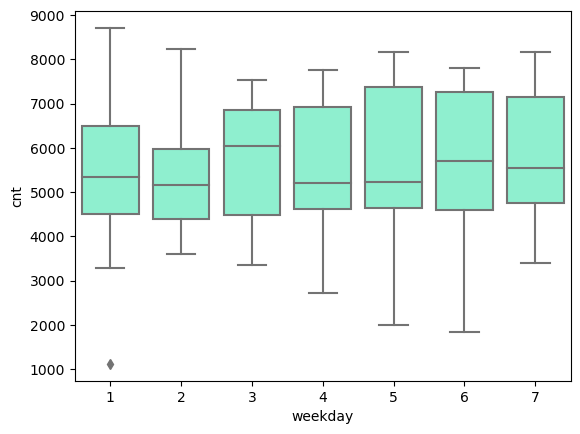

In [312]:
sns.boxplot(
        data = dfv,
        x = 'weekday',
        y = 'cnt',
        color = "aquamarine")

<AxesSubplot:xlabel='mnth', ylabel='cnt'>

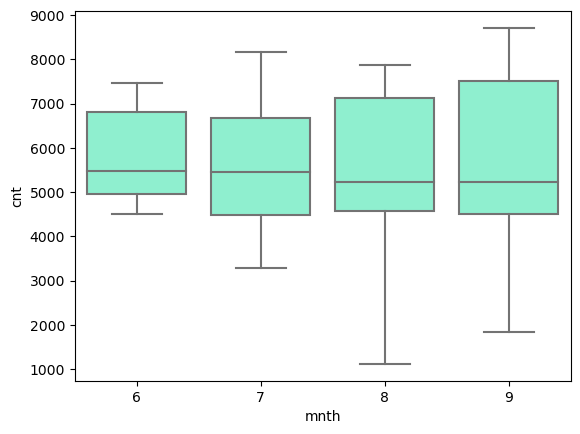

In [313]:
sns.boxplot(
        data = dfv,
        x = 'mnth',
        y = 'cnt',
        color = "aquamarine")

In [314]:
# Gráfico de relación entre variables predictoras y la variable a predecir
# ==============================================================================


#fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (30, 10))


#axes = axes.flat

#columnas_numeric = dfv.select_dtypes(include = np.number).columns
#columnas_numeric = columnas_numeric.drop(["cnt",'instant'])

#for i, colum in enumerate(columnas_numeric):
    #sns.regplot(
       # x = dfv[colum], 
       # y = dfv["cnt"], 
       # color = "gray", 
       # marker = ".", 
       # scatter_kws = {"alpha": 0.4}, 
       # line_kws = {"color": "red", "alpha": 0.7 }, 
       # ax = axes[i])
    
    #axes[i].set_title(f"cnt vs {colum}", fontsize = 10, fontweight = "bold")
    #axes[i].tick_params(labelsize = 20)
    #axes[i].set_xlabel("")
    #axes[i].set_ylabel("")
    
#fig.tight_layout()
#fig.delaxes(axes[-1])
#fig.delaxes(axes[-2])
#fig.delaxes(axes[-3]);

#### Correlación entre variables numéricas

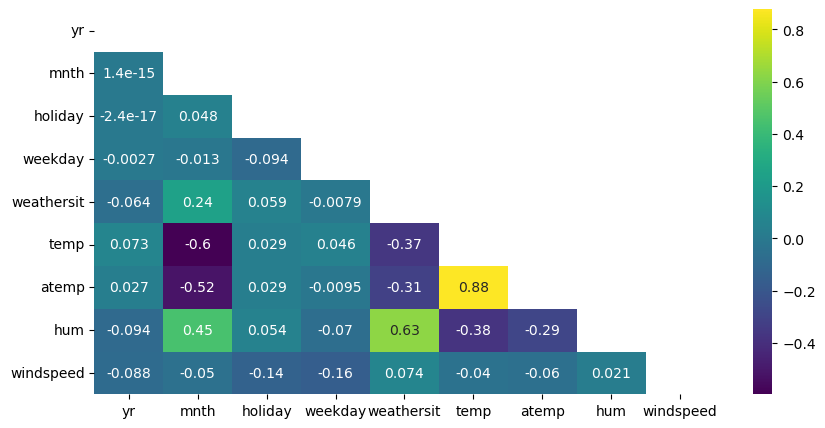

In [315]:
# Hacemos un heatmap con las variables numéricas contínuas
numeric = (dfv.select_dtypes(include = np.number)).drop(['cnt','instant'], axis=1)
correlacion = numeric.corr()
plt.figure(figsize=(10,5))
mask = np.triu(np.ones_like(correlacion, dtype=bool))
sns.heatmap(correlacion, cmap="viridis", annot = True, mask = mask); #barra lateral

In [316]:
# Eliminamos columnas que interfieren en el resultado:
    #temperatura

In [317]:
dfv=dfv.drop(['temp'],axis=1) 

In [318]:
dfv['yr'].unique()

array([0, 1])

#### Variables categóricas

In [319]:
categoricas # solo tenemos una, no la analizamos

,dteday,season
0,2018-06-21,summer
1,2018-06-22,summer
2,2018-06-23,summer
3,2018-06-24,summer
4,2018-06-25,summer
...,...,...
183,2019-09-18,summer
184,2019-09-19,summer
185,2019-09-20,summer
186,2019-09-21,summer


In [320]:
dfv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     188 non-null    int64  
 1   dteday      188 non-null    object 
 2   season      188 non-null    object 
 3   yr          188 non-null    int64  
 4   mnth        188 non-null    int64  
 5   holiday     188 non-null    int64  
 6   weekday     188 non-null    int64  
 7   weathersit  188 non-null    int64  
 8   atemp       188 non-null    float64
 9   hum         188 non-null    float64
 10  windspeed   188 non-null    float64
 11  cnt         188 non-null    int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 17.8+ KB


## Encoding las variables yr, mnth, holiday, weekday, weather

In [321]:
dfv['yr'].unique()

array([0, 1])

In [322]:
dfv['yr'] = dfv['yr'].map({0:1, 1:2})
dfv['weekday'] = dfv['weekday'].map({2:1,4:1,5:1,1:1, 6:2, 7:2, 3:3})
dfv['weathersit'] = dfv['weathersit'].map({1:3,2:2,3:1})

In [323]:
dfv['yr'].unique()

array([1, 2])

In [324]:
dummies = pd.get_dummies(df['mnth'], prefix_sep = "_", prefix = "month", dtype = int)
dummies2 = pd.get_dummies(df['holiday'], prefix_sep = "_", prefix = "holiday", dtype = int)

In [325]:
dfv.reset_index()

,index,instant,dteday,season,yr,mnth,holiday,weekday,weathersit,atemp,hum,windspeed,cnt
0,0,172,2018-06-21,summer,1,6,0,1,2,31.88230,77.0417,11.458675,4835
1,1,173,2018-06-22,summer,1,6,0,1,3,34.69145,70.7500,11.541554,4507
2,2,174,2018-06-23,summer,1,6,0,2,2,34.69165,70.3333,15.999868,4790
3,3,175,2018-06-24,summer,1,6,0,2,3,32.82915,57.3333,14.875675,4991
4,4,176,2018-06-25,summer,1,6,0,1,3,32.16565,48.3333,14.041257,5202
...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,183,626,2019-09-18,summer,2,9,0,1,2,28.25335,87.2500,23.958329,4073
184,184,627,2019-09-19,summer,2,9,0,1,3,27.02020,53.6667,14.416725,7591
185,185,628,2019-09-20,summer,2,9,0,2,3,26.60960,61.8333,7.917189,7720
186,186,629,2019-09-21,summer,2,9,0,2,3,28.59855,66.8750,10.333343,8167


In [328]:
dummies.reset_index()

,index,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,0,0,0,0,0,0,0
4,4,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,725,0,0,0,0,0,0,0,0,0,0,0,1
726,726,0,0,0,0,0,0,0,0,0,0,0,1
727,727,0,0,0,0,0,0,0,0,0,0,0,1
728,728,0,0,0,0,0,0,0,0,0,0,0,1


In [326]:
df_dummies = pd.concat([dfv, dummies], axis = 1)
df_dummies.head()

,instant,dteday,season,yr,mnth,holiday,weekday,weathersit,atemp,hum,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,172.0,2018-06-21,summer,1.0,6.0,0.0,1.0,2.0,31.88230,77.0417,...,0,0,0,0,0,0,0,0,0,0
1,173.0,2018-06-22,summer,1.0,6.0,0.0,1.0,3.0,34.69145,70.7500,...,0,0,0,0,0,0,0,0,0,0
2,174.0,2018-06-23,summer,1.0,6.0,0.0,2.0,2.0,34.69165,70.3333,...,0,0,0,0,0,0,0,0,0,0
3,175.0,2018-06-24,summer,1.0,6.0,0.0,2.0,3.0,32.82915,57.3333,...,0,0,0,0,0,0,0,0,0,0
4,176.0,2018-06-25,summer,1.0,6.0,0.0,1.0,3.0,32.16565,48.3333,...,0,0,0,0,0,0,0,0,0,0


In [329]:
df_dummies = pd.concat([df_dummies, dummies2], axis = 1)
df_dummies.head()

,instant,dteday,season,yr,mnth,holiday,weekday,weathersit,atemp,hum,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,holiday_0,holiday_1
0,172.0,2018-06-21,summer,1.0,6.0,0.0,1.0,2.0,31.88230,77.0417,...,0,0,0,0,0,0,0,0,0,1
1,173.0,2018-06-22,summer,1.0,6.0,0.0,1.0,3.0,34.69145,70.7500,...,0,0,0,0,0,0,0,0,1,0
2,174.0,2018-06-23,summer,1.0,6.0,0.0,2.0,2.0,34.69165,70.3333,...,0,0,0,0,0,0,0,0,1,0
3,175.0,2018-06-24,summer,1.0,6.0,0.0,2.0,3.0,32.82915,57.3333,...,0,0,0,0,0,0,0,0,1,0
4,176.0,2018-06-25,summer,1.0,6.0,0.0,1.0,3.0,32.16565,48.3333,...,0,0,0,0,0,0,0,0,1,0


In [330]:
df_dummies.isnull().sum()

instant       542
dteday        542
season        542
yr            542
mnth          542
holiday       542
weekday       542
weathersit    542
atemp         542
hum           542
windspeed     542
cnt           542
month_1         0
month_2         0
month_3         0
month_4         0
month_5         0
month_6         0
month_7         0
month_8         0
month_9         0
month_10        0
month_11        0
month_12        0
holiday_0       0
holiday_1       0
dtype: int64

## Estudiamos la normalidad de los datos de la variable respuesta (cnt)

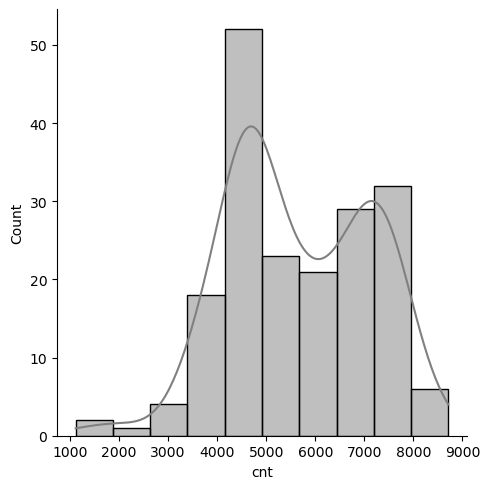

In [198]:
sns.displot(dfv['cnt'], kde = True, color = "grey");

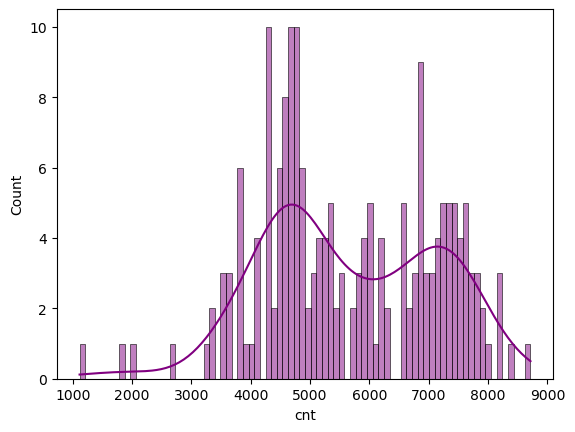

In [199]:
sns.histplot(dfv['cnt'],bins=80, kde=True, color = 'purple');


Calculamos el shapiro test

In [200]:
stats.shapiro(dfv['cnt'])

ShapiroResult(statistic=0.9631569981575012, pvalue=7.678098336327821e-05)

Como sospechabamos con los graficos, el pvalor es inferior a 0.05, por lo que podemos decir que nuestros datos no son normales.

### Normalizamos los datos

In [201]:
# boxcox
dfv['cnt_box'], lambda_ajustada = stats.boxcox(dfv['cnt'])

In [202]:
dfv.head()

,instant,dteday,season,yr,mnth,holiday,weekday,weathersit,atemp,hum,windspeed,cnt,cnt_box
0,172,2018-06-21,summer,NaN,6,0,1,2,31.88230,77.0417,11.458675,4835,8439.080631
1,173,2018-06-22,summer,NaN,6,0,1,3,34.69145,70.7500,11.541554,4507,7825.677729
2,174,2018-06-23,summer,NaN,6,0,2,2,34.69165,70.3333,15.999868,4790,8354.737285
3,175,2018-06-24,summer,NaN,6,0,2,3,32.82915,57.3333,14.875675,4991,8731.918222
4,176,2018-06-25,summer,NaN,6,0,1,3,32.16565,48.3333,14.041257,5202,9129.076629


In [203]:
dfv.head()

,instant,dteday,season,yr,mnth,holiday,weekday,weathersit,atemp,hum,windspeed,cnt,cnt_box
0,172,2018-06-21,summer,NaN,6,0,1,2,31.88230,77.0417,11.458675,4835,8439.080631
1,173,2018-06-22,summer,NaN,6,0,1,3,34.69145,70.7500,11.541554,4507,7825.677729
2,174,2018-06-23,summer,NaN,6,0,2,2,34.69165,70.3333,15.999868,4790,8354.737285
3,175,2018-06-24,summer,NaN,6,0,2,3,32.82915,57.3333,14.875675,4991,8731.918222
4,176,2018-06-25,summer,NaN,6,0,1,3,32.16565,48.3333,14.041257,5202,9129.076629


<AxesSubplot:xlabel='cnt_box', ylabel='Count'>

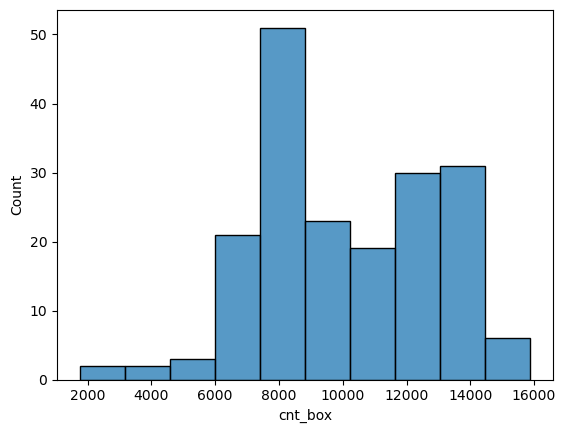

In [204]:
sns.histplot(data = dfv, x = 'cnt_box')

In [205]:
stats.shapiro(dfv['cnt_box']) # No son normales

ShapiroResult(statistic=0.963170051574707, pvalue=7.703298615524545e-05)

In [206]:
#minmaxscaller
from sklearn.preprocessing import MinMaxScaler
MinMaxScaler (feature_range=(0,1), copy=True, clip=False)
minmax= MinMaxScaler()
values = dfv['cnt'].values.reshape(-1,1)
minmax.fit(values)
x_normalizafas = minmax.transform(values)
numericas_minmax = pd.DataFrame(x_normalizafas, columns = ['col_sklearn'])
dfv['col_sklearn'] = numericas_minmax


<AxesSubplot:xlabel='col_sklearn', ylabel='Count'>

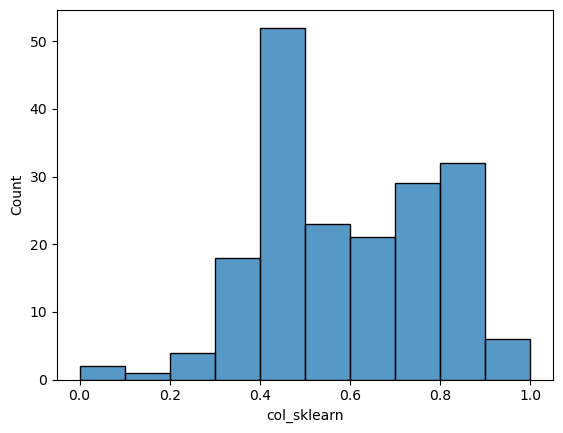

In [207]:
sns.histplot(data = dfv, x = 'col_sklearn')

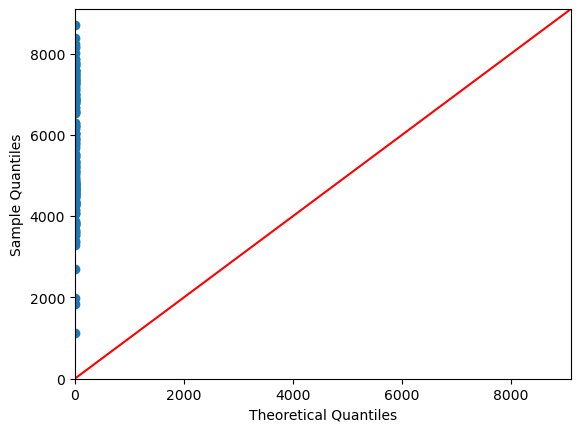

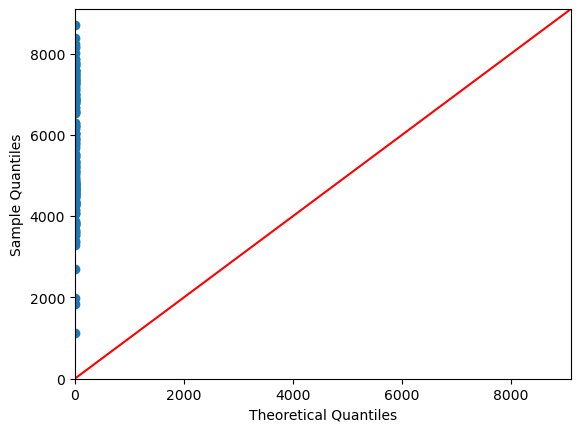

In [208]:
import statsmodels.api as sm
sm.qqplot(dfv['cnt'], line='45')

## Asuncion de independencia

In [209]:
dfv.head()

,instant,dteday,season,yr,mnth,holiday,weekday,weathersit,atemp,hum,windspeed,cnt,cnt_box,col_sklearn
0,172,2018-06-21,summer,NaN,6,0,1,2,31.88230,77.0417,11.458675,4835,8439.080631,0.489538
1,173,2018-06-22,summer,NaN,6,0,1,3,34.69145,70.7500,11.541554,4507,7825.677729,0.446375
2,174,2018-06-23,summer,NaN,6,0,2,2,34.69165,70.3333,15.999868,4790,8354.737285,0.483616
3,175,2018-06-24,summer,NaN,6,0,2,3,32.82915,57.3333,14.875675,4991,8731.918222,0.510067
4,176,2018-06-25,summer,NaN,6,0,1,3,32.16565,48.3333,14.041257,5202,9129.076629,0.537834


In [210]:
# en este ejemplo evaluaremos la independencia entre dos de nuestras columnas: 

crosstab, test_results, expected = rp.crosstab(dfv["dteday"], df["mnth"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")


In [211]:
# crosstab- 🚨 La usaremos para comparar dos variables categóricas, aunque para esta lección hemos usado una categórica y una numérica ya que no tenemos dos categóricas.
crosstab.head()

mnth                                    
mnth           1    2    3    4    5    6    7   All
dteday                                              
2018-06-21  0.53  0.0  0.0  0.0  0.0  0.0  0.0  0.53
2018-06-22  0.53  0.0  0.0  0.0  0.0  0.0  0.0  0.53
2018-06-23  0.53  0.0  0.0  0.0  0.0  0.0  0.0  0.53
2018-06-24  0.53  0.0  0.0  0.0  0.0  0.0  0.0  0.53
2018-06-25  0.53  0.0  0.0  0.0  0.0  0.0  0.0  0.53

In [212]:
test_results

,Chi-square test,results
0,Pearson Chi-square ( 1122.0) =,1128.0000
1,p-value =,0.4441
2,Cramer's V =,1.0000


## Homogeneidad de varianzas

### variables numericas

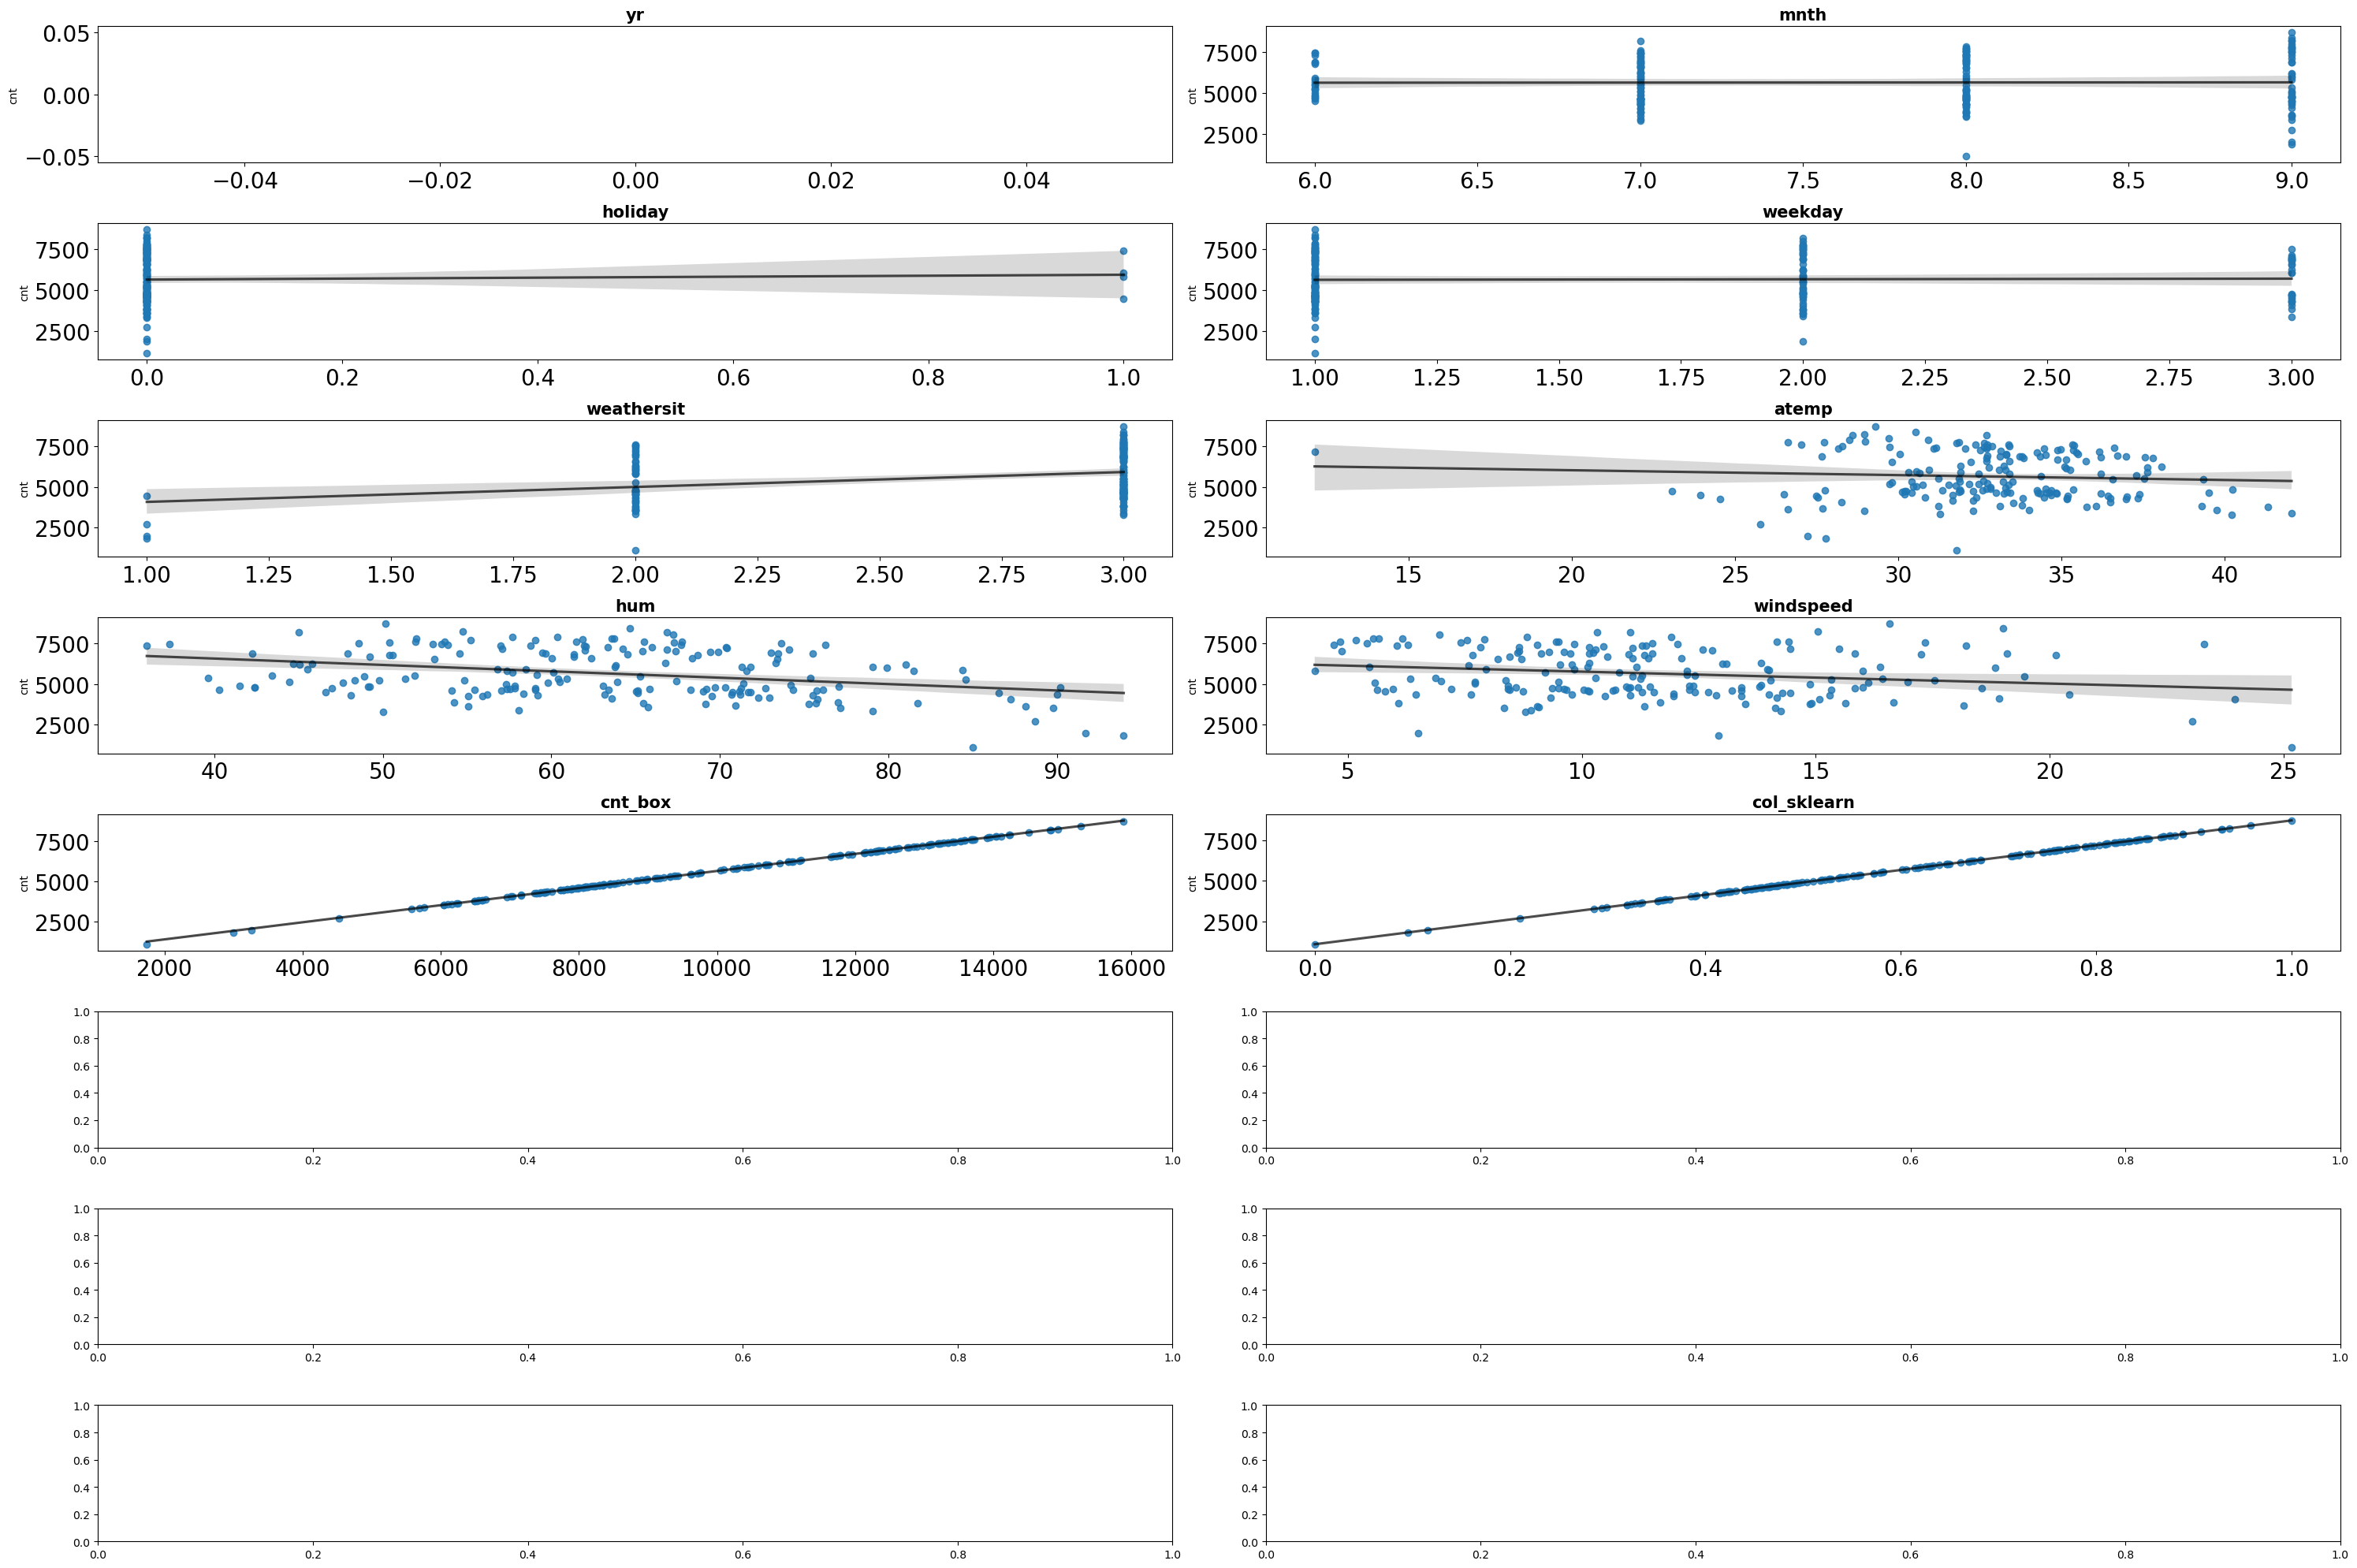

In [213]:
# iniciamos los subplots
fig, axes = plt.subplots(nrows = 8, ncols = 2, figsize = (30, 20))

# definimos una lista de colores. Cada color corresponderá a una gráfica
lista_colores = ["blue", "green", "red", "cyan", "magenta", "orange"]

# hemos creado una gráfica con varios subplots. Si queremos automatizar el proceso de relleno de cada uno de los plots
## podemos usar el método .flat. Lo que hace es aplanar los ejes para que queden en una única dimensión
## y luego los vamos rellenando. 
axes = axes.flat

# seleccionamos las columnas que queremos graficar
columnas_numeric = dfv.select_dtypes(include = np.number).drop(['cnt','instant'], axis=1)
columnas_numeric = columnas_numeric.columns

# iniciamos un for loop para no tener que escribir la misma línea de código muchas veces
for i, colum in enumerate(columnas_numeric): 
    sns.regplot(
        data = dfv,
        x = colum,
        y = 'cnt',
        #color = lista_colores[i],
        line_kws = {"color": "black", "alpha": 0.7 }, 
        ax = axes[i])
    
    # establecemos el título de cada gráfica
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")

    # establacemos el tamaño de la letras de los ejes
    axes[i].tick_params(labelsize = 20)

    # establecemos que no queremos que aparezca nada en el eje x
    axes[i].set_xlabel("")
    
# ajustamos el tamaño de cada subplot para que no se vean superpuestos. 
fig.tight_layout();

In [214]:
dfv.head()

,instant,dteday,season,yr,mnth,holiday,weekday,weathersit,atemp,hum,windspeed,cnt,cnt_box,col_sklearn
0,172,2018-06-21,summer,NaN,6,0,1,2,31.88230,77.0417,11.458675,4835,8439.080631,0.489538
1,173,2018-06-22,summer,NaN,6,0,1,3,34.69145,70.7500,11.541554,4507,7825.677729,0.446375
2,174,2018-06-23,summer,NaN,6,0,2,2,34.69165,70.3333,15.999868,4790,8354.737285,0.483616
3,175,2018-06-24,summer,NaN,6,0,2,3,32.82915,57.3333,14.875675,4991,8731.918222,0.510067
4,176,2018-06-25,summer,NaN,6,0,1,3,32.16565,48.3333,14.041257,5202,9129.076629,0.537834


In [215]:
dfv.drop(['cnt_box','col_sklearn','dteday'], axis=1, inplace=True)

> ### Decision Tree

1º lo hacemos con todas las variables menos instant, dteday y season

In [216]:
df_dummies.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'weathersit', 'atemp', 'hum', 'windspeed', 'cnt', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'holiday_0',
       'holiday_1'],
      dtype='object')

In [217]:
df_dummies.drop(df_dummies[['instant','season', 'mnth', 'holiday', 'dteday']], axis=1, inplace = True)

In [221]:
df_dummies.isnull().sum()

yr            730
weekday       542
weathersit    542
atemp         542
hum           542
windspeed     542
cnt           542
month_1         0
month_2         0
month_3         0
month_4         0
month_5         0
month_6         0
month_7         0
month_8         0
month_9         0
month_10        0
month_11        0
month_12        0
holiday_0       0
holiday_1       0
dtype: int64

In [218]:
# al igual que en la regresión lineal tenemos que separar nuestro dataframe en X e y

X = df_dummies.drop("cnt", axis = 1)
y = df_dummies["cnt"]

In [219]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Ajustamos el modelo

In [280]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train, y_train)



ValueError: Input X contains NaN.
DecisionTreeRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Una vez entrenado el árbol, se puede representar mediante la combinación de las funciones plot_tree(). La función plot_tree() dibuja la estructura del árbol y muestra el número de observaciones y valor medio de la variable respuesta en cada nodo.

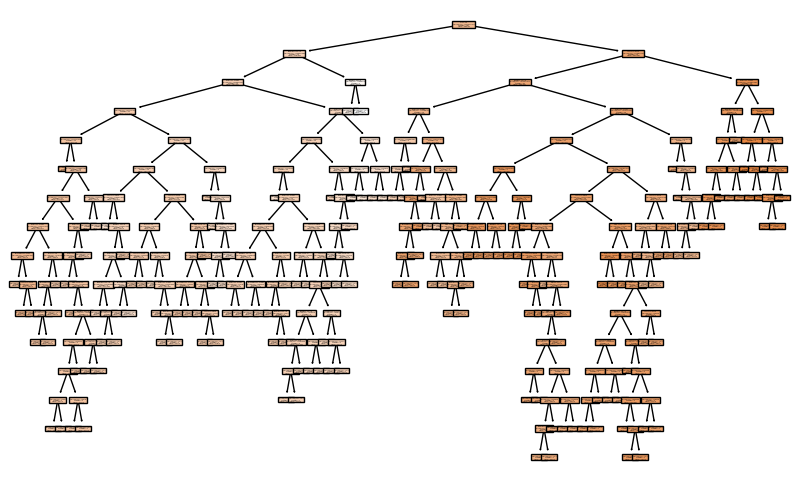

In [62]:
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train.columns, filled = True)
plt.show()

In [63]:
# max features. Como vemos, debemos poner en nuestro modelo una profudidad máxima de 4. 

max_features = np.sqrt(len(x_train.columns))
max_features

3.1622776601683795

In [64]:

# max depth

print(arbol.tree_.max_depth)

15


In [65]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

#### Metricas

In [66]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [67]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results

,MAE,MSE,RMSE,R2,set,modelo
0,792.421053,1.275554e+06,1129.404128,0.463611,test,Decission Tree I
1,0.000000,0.000000e+00,0.000000,1.000000,train,Decission Tree I


In [68]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param = {"max_depth": [2,4, 6], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 


In [69]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [70]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6], 'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [71]:
# este método nos esta diciendo que el mejor modelo es aquel que tiene una profundidad de 6, que usa 4 variables predictoras para construir el modelo y que tiene  un min_samples_leaf y un min_samples_split de 10. 
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=6, max_features=4, min_samples_leaf=10,
                      min_samples_split=10)

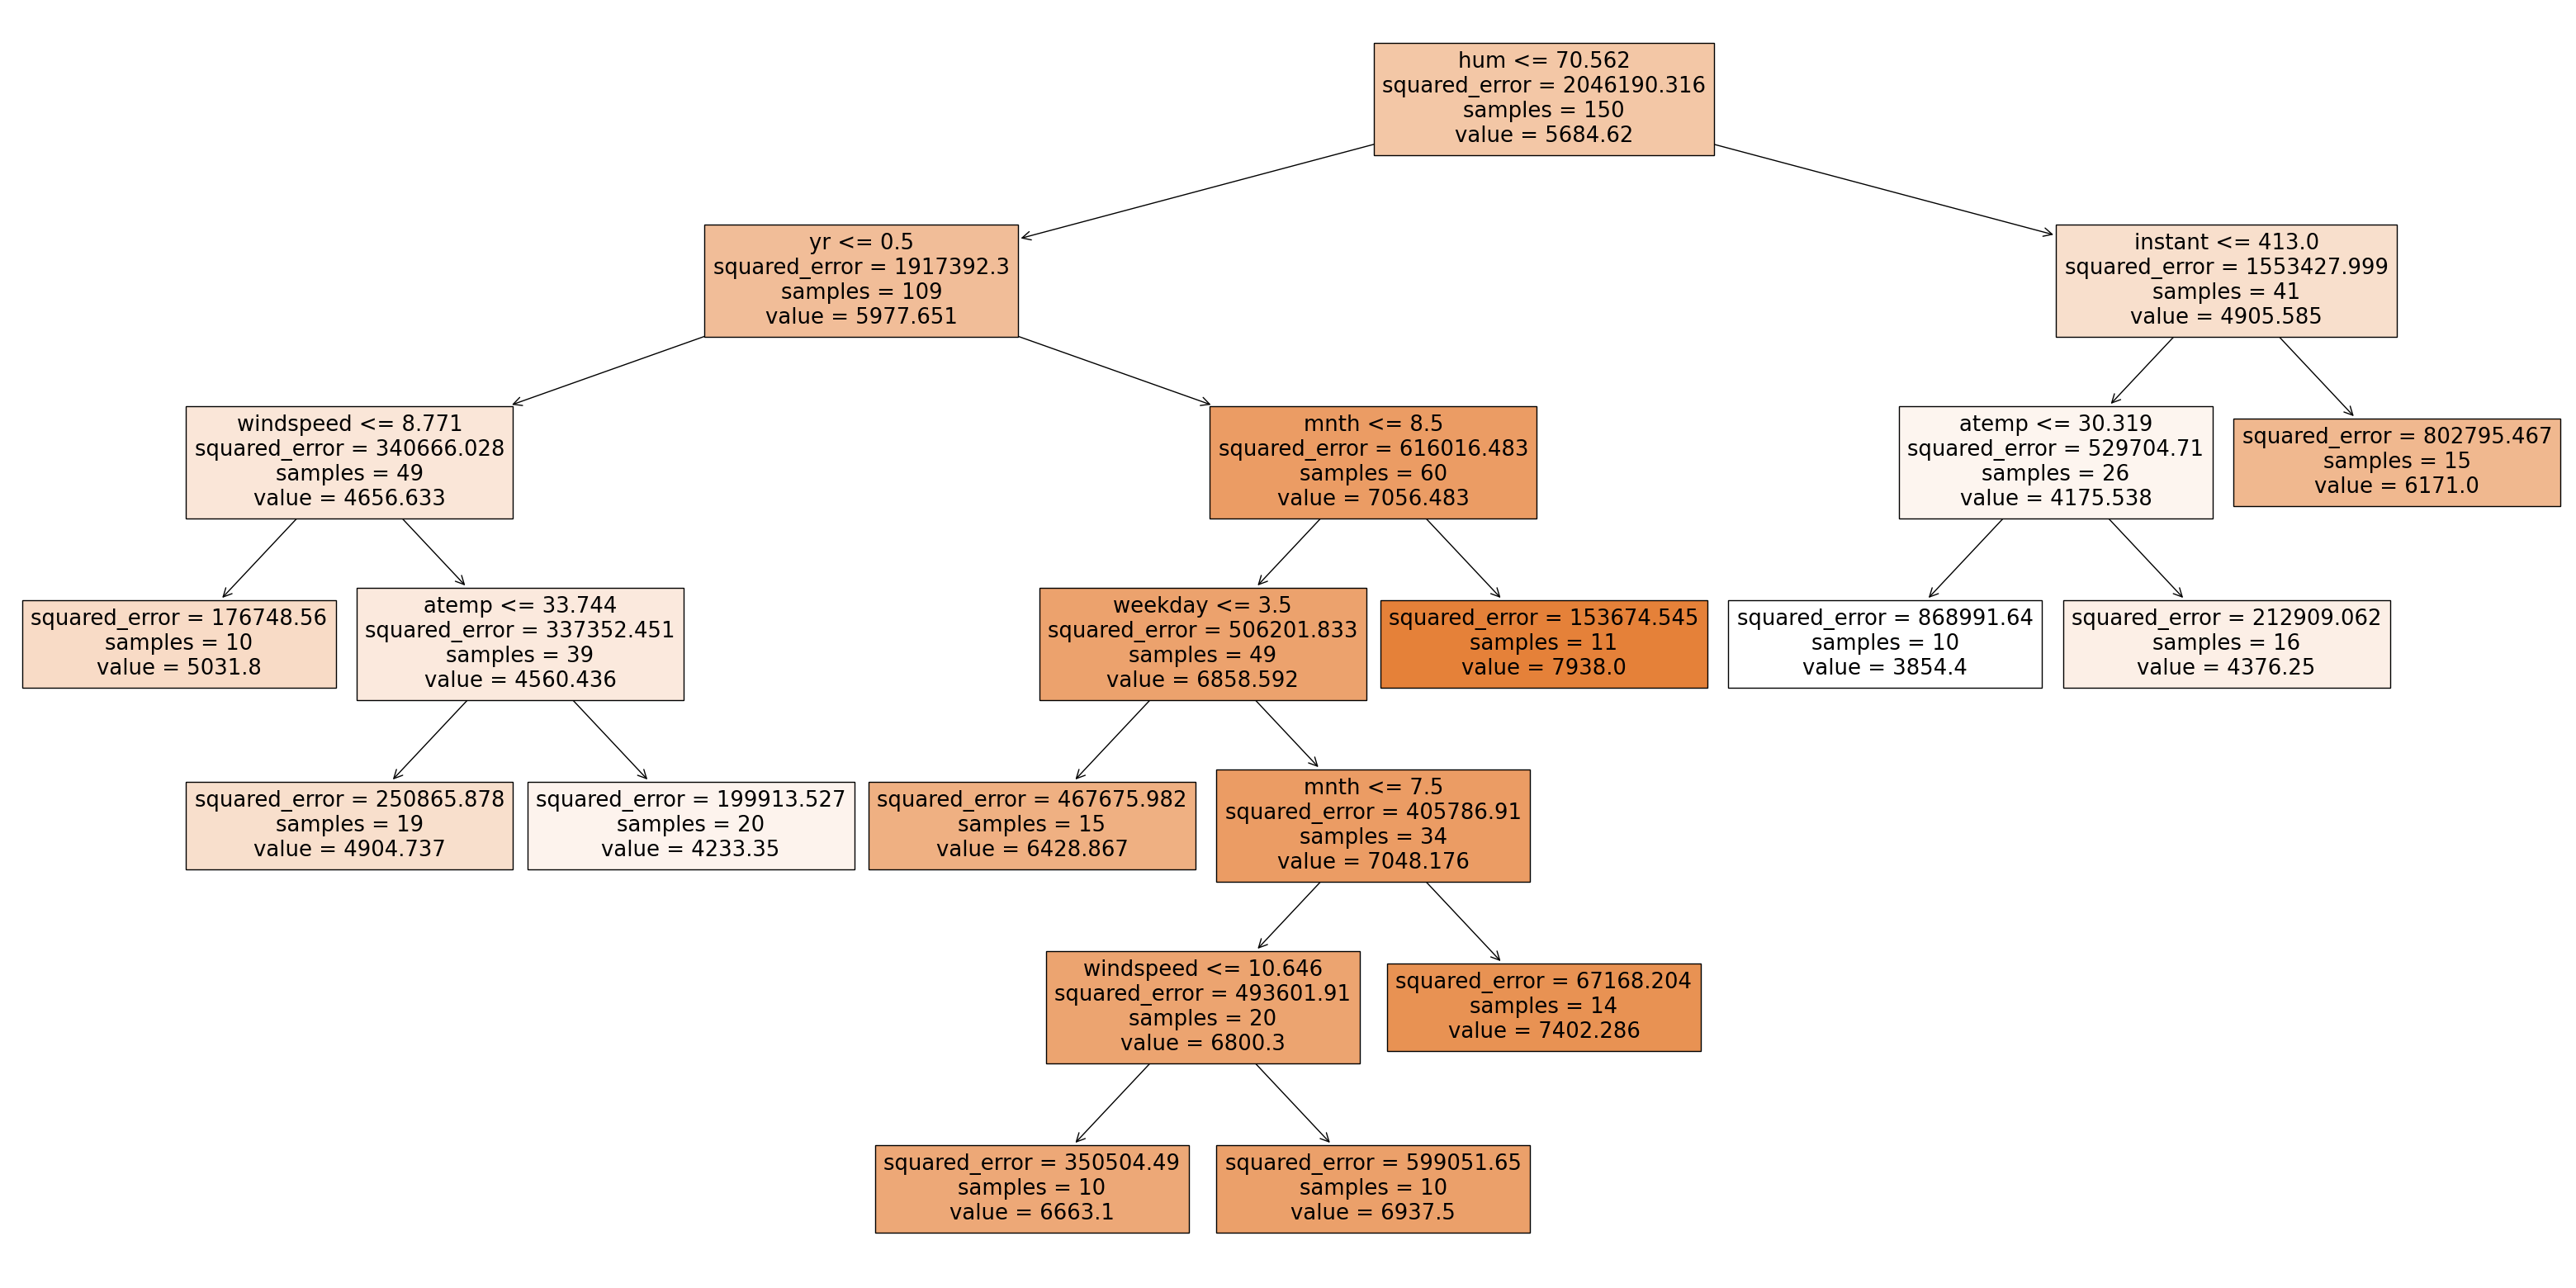

In [72]:
# veamos ahora que pinta tiene nuestro árbol


fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train.columns, filled=True);

In [73]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [74]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2



,MAE,MSE,RMSE,R2,set,modelo
0,655.818546,906360.770840,952.029816,0.618862,test,Decision tree II
1,461.897833,358747.181498,598.955075,0.824676,train,Decision tree II


In [75]:
# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results, dt_results2], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,792.421053,1.275554e+06,1129.404128,0.463611,test,Decission Tree I
1,0.000000,0.000000e+00,0.000000,1.000000,train,Decission Tree I
0,655.818546,9.063608e+05,952.029816,0.618862,test,Decision tree II
1,461.897833,3.587472e+05,598.955075,0.824676,train,Decision tree II


In [76]:

# vamos a crearnos un dataframe 
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores


Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
2,yr,0.613718
0,instant,0.149640
8,hum,0.135283
3,mnth,0.053142
7,atemp,0.023973
5,weekday,0.015771
9,windspeed,0.008474
1,season,0.000000
4,holiday,0.000000
6,weathersit,0.000000


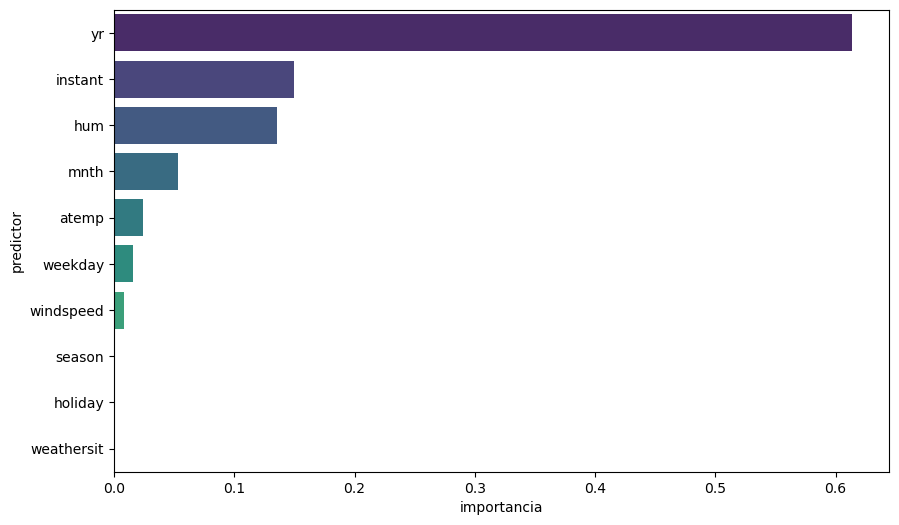

In [77]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()

> # Random Forest

In [78]:
param = {"max_depth": [2,4, 6], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 

In [79]:
gs_rf = GridSearchCV(
            estimator=RandomForestRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [80]:
gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, 6], 'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [81]:
bosque = gs_rf.best_estimator_
bosque

RandomForestRegressor(max_depth=4, max_features=4, min_samples_leaf=10,
                      min_samples_split=10)

In [82]:
# dibujemos los árboles de nuestro bosque


#for arbol in tqdm(bosque.estimators_):
#    fig = plt.figure(figsize=(40, 20))
#    tree.plot_tree(arbol, feature_names= x_train.columns, filled = True)
#    plt.show()

In [83]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

In [84]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [85]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest")
dt_results

,MAE,MSE,RMSE,R2,set,modelo
0,624.050737,895636.803671,946.380898,0.623371,test,Random Forest
1,425.868262,346824.139720,588.917770,0.830503,train,Random Forest


In [86]:

# vamos a crearnos un dataframe, igual que hicimos en la clase anterior con la importancia de cada una de las variables incluidas en el modelo

importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': bosque.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores


Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,instant,0.514021
2,yr,0.341178
8,hum,0.050203
7,atemp,0.042970
9,windspeed,0.017954
5,weekday,0.015655
6,weathersit,0.009174
3,mnth,0.008844
1,season,0.000000
4,holiday,0.000000


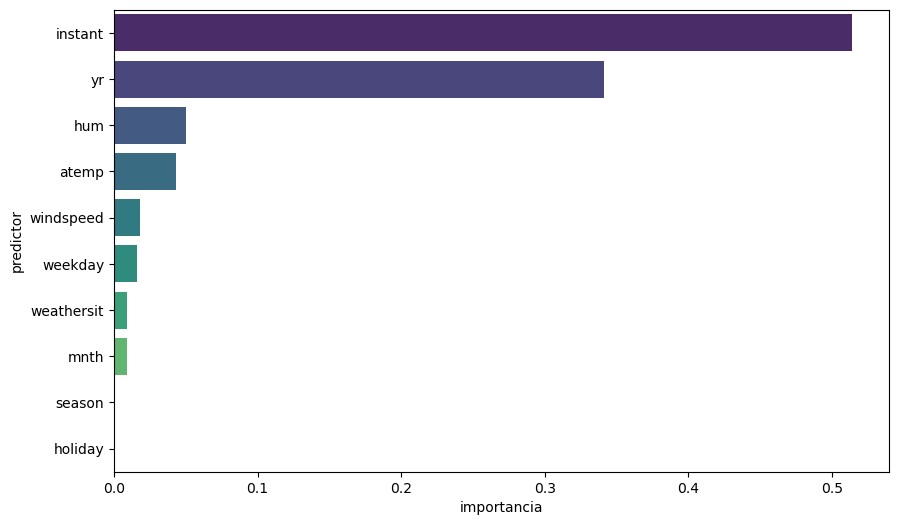

In [87]:

# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()